In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
dim = 2
origin = [[0.,0.], [10.,0.]]
radius = [2., 1.]
nb_pts = [10, 7]

data = regdata.PointCircles()
#data(nb_pts, origin, radius, transvec = [[10., 0.], [-10.,0.]], scal=1)
data(nb_pts, origin, radius, transvec = [[0., 5.], [0.,-5.]], scal=1)


source = data.source
target = data.target

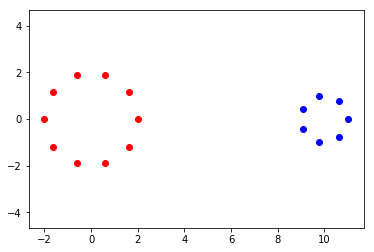

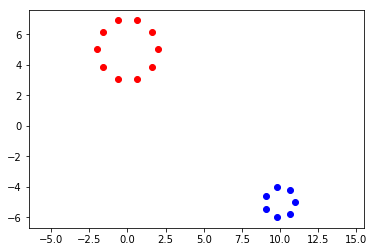

In [3]:
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 3
manifold1 = dm.manifold.Landmarks(dim, nb_pts[0], gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)
silent1 = dm.deformationmodules.SilentPoints(manifold1)
mod1 = dm.deformationmodules.CompoundModule([silent1, trans1])


sigma2 = 3
manifold2 = dm.manifold.Landmarks(dim, nb_pts[1], gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
silent2 = dm.deformationmodules.SilentPoints(manifold2)
mod2 = dm.deformationmodules.CompoundModule([silent2, trans2])

module_list = [mod1, mod2]
sigma_bg = 0.1

modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
constr_Id = dm.constraints.Identity_Silent()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [6]:
my_model = dm.models.ModelMultishapePointsRegistration(source, modules.module_list[:-1], sigma_bg,  dm.attachement.L2NormAttachement_multi(), constr_Id)
costs = my_model.fit(target, lr=1e-4, l=1, max_iter=200, log_interval=5)

It: 0, deformation cost: 0.000000, attach: 15.811388. Total cost: 15.811388
It: 5, deformation cost: 0.000144, attach: 15.665253. Total cost: 15.665397
It: 10, deformation cost: 0.014912, attach: 14.336013. Total cost: 14.350925
It: 15, deformation cost: 0.032779, attach: 13.620368. Total cost: 13.653147
It: 20, deformation cost: 0.051514, attach: 13.060961. Total cost: 13.112474
It: 25, deformation cost: 0.070168, attach: 12.597675. Total cost: 12.667843
It: 30, deformation cost: 0.088519, attach: 12.198242. Total cost: 12.286761
It: 35, deformation cost: 0.106484, attach: 11.845060. Total cost: 11.951543
It: 40, deformation cost: 0.124028, attach: 11.527437. Total cost: 11.651465
It: 45, deformation cost: 0.141137, attach: 11.238326. Total cost: 11.379463
It: 50, deformation cost: 0.157804, attach: 10.972787. Total cost: 11.130590
It: 55, deformation cost: 0.174029, attach: 10.727194. Total cost: 10.901224
It: 60, deformation cost: 0.189817, attach: 10.498787. Total cost: 10.688604
I

In [11]:
my_model.shot_manifold.gd, target

([[tensor([ 1.7045,  2.9673,  1.3870,  3.9474,  0.5317,  4.5734, -0.5320,  4.5734,
           -1.3874,  3.9474, -1.7048,  2.9673, -1.3706,  2.0401, -0.5212,  1.5034,
            0.5209,  1.5033,  1.3703,  2.0401], grad_fn=<CloneBackward>),
   tensor([ 1.7045,  2.9673,  1.3870,  3.9474,  0.5317,  4.5734, -0.5320,  4.5734,
           -1.3874,  3.9474, -1.7048,  2.9673, -1.3706,  2.0401, -0.5212,  1.5034,
            0.5209,  1.5033,  1.3703,  2.0401], grad_fn=<CloneBackward>)],
  [tensor([11.0000,  0.0000, 10.6235,  0.7818,  9.7775,  0.9749,  9.0990,  0.4339,
            9.0990, -0.4339,  9.7775, -0.9749, 10.6235, -0.7818],
          grad_fn=<CloneBackward>),
   tensor([11.0000,  0.0000, 10.6235,  0.7818,  9.7775,  0.9749,  9.0990,  0.4339,
            9.0990, -0.4339,  9.7775, -0.9749, 10.6235, -0.7818],
          grad_fn=<CloneBackward>)],
  [tensor([ 1.9292,  0.0190,  1.5629,  1.1469,  0.5975,  1.8490, -0.5975,  1.8490,
           -1.5629,  1.1469, -1.9292,  0.0190, -1.5585, -1.0986, 

In [12]:
my_model.compute(target)
#shot_gd = my_model()
shot_source = [man.manifold_list[0].gd for man in my_model.shot_manifold[:-1]]

plt.scatter(shot_source[0].view(-1,2)[:, 0].detach().numpy(),shot_source[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(shot_source[1].view(-1,2)[:, 0].detach().numpy(),shot_source[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')
plt.show()

In [7]:
out = my_model()
%matplotlib qt5
#plt.subplot(1, 2, 1)
#dm.usefulfunctions.plot_tensor_scatter(target[0], alpha=0.4)
#dm.usefulfunctions.plot_tensor_scatter(source[0], alpha=0.4)
#ax = plt.subplot(1, 2, 2)
#dm.usefulfunctions.plot_tensor_scatter(target[0], alpha=0.4)
#dm.usefulfunctions.plot_tensor_scatter(out[0][0], alpha=0.4)
#plt.plot(my_model.shot_manifold[1].gd[0].detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[1].gd[0].detach().view(-1, 2)[:, 0].numpy(), '.')
#plt.plot(my_model.shot_manifold[2].gd[0].detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[2].gd[0].detach().view(-1, 2)[:, 0].numpy(), '.')
gridpos_x, gridpos_y = my_model.compute_deformation_grid(torch.tensor([-2, -2]), torch.tensor([12, 12]), torch.tensor([16, 16]))
dm.usefulfunctions.plot_grid(ax, gridpos_y.detach().numpy(), gridpos_x.detach().numpy(), color='C0')
#plt.show()


AttributeError: 'SilentPoints' object has no attribute 'module_list'

In [9]:
grid_origin = [0,0]
grid_size = [10,10]
grid_resolution = [16, 16]

x, y = torch.meshgrid([
            torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
            torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

gridpos = dm.usefulfunctions.grid2vec(x, y)

grid_landmarks = dm.manifold.Landmarks(2, gridpos.shape[0], gd=gridpos.view(-1))
grid_silent = dm.deformationmodules.SilentPoints(grid_landmarks)
        
boundary_labels = [np.zeros(grid_landmarks.nb_pts), *[np.ones(mod.manifold.nb_pts) for mod in module_list]]
        
multi_silent = dm.multishape.MultiShapeModule([grid_silent, *module_list], sigma_bg, boundary_labels)

In [20]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)


test_gradcheck_Hamiltonian()

True

In [8]:
module_list

In [14]:
def test_gradcheck_model():
    def model(gd0, gd1, mom0, mom1):
        
        module_list[0].manifold.fill_gd(gd0)
        module_list[0].manifold.fill_cotan(mom0)
        module_list[1].manifold.fill_gd(gd1)
        module_list[1].manifold.fill_cotan(mom1)
        
        model = dm.models.ModelMultishapePointsRegistration(source, module_list, sigma_bg,  dm.attachement.L2NormAttachement_multi(), constr_Id)
        model.compute(target)
        
        return model.attach
    return torch.autograd.gradcheck(model, (gd[0], gd[1], mom[0], mom[1]), raise_exception=True)

gd = [10*torch.rand(mod.manifold.numel_gd, requires_grad=True) for mod in module_list]
mom = [torch.rand(mod.manifold.numel_gd, requires_grad=True) for mod in module_list]

test_gradcheck_model()

RuntimeError: Jacobian mismatch for output 0 with respect to input 0,
numerical:tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.2753],
        [ 0.3938],
        [ 0.4522],
        [ 0.6506],
        [ 0.5730],
        [-0.2520],
        [ 0.9310],
        [-1.1611],
        [-0.4659],
        [ 0.2741],
        [ 0.0998],
        [-0.3811],
        [ 0.9264],
        [ 1.0181],
        [-0.2067],
        [-0.8382],
        [-0.4639],
        [ 0.6465],
        [ 1.0204],
        [ 0.1456]])
analytical:tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
